In [23]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt 



In [6]:
path = os.listdir('../data/tumor/Training/')
classes = {'no_tumor': 0, 'pituitary_tumor': 1}

In [7]:
X = []
Y = []

for cls in classes:
    pth = '../data/tumor/Training/' + cls
    for j in os.listdir(pth):
        img = cv2.imread(pth + '/' + j, 0)
        img = cv2.resize(img, (200, 200))
        X.append(img)
        Y.append(classes[cls])
X_updated = np.array(X).reshape(len(X), -1)
Y = np.array(Y)


In [8]:
def train_test_split_custom(X, Y, test_size=0.2, random_state=None):
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    split_index = int(len(X) * (1 - test_size))
    train_indices, test_indices = indices[:split_index], indices[split_index:]
    return X[train_indices], X[test_indices], Y[train_indices], Y[test_indices]

xtrain, xtest, ytrain, ytest = train_test_split_custom(X_updated, Y, test_size=0.20, random_state=10)

In [10]:
xtrain = xtrain / 255
xtest = xtest / 255

In [12]:
def pca_custom(X, threshold=0.98):
    if X.ndim == 1:
        X = np.expand_dims(X, axis=0)  # Expand dimensions to make X 2D if it's 1D
    cov_matrix = np.cov(X, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Add a small positive offset to eigenvalues to ensure they are positive
    eigenvalues = np.maximum(eigenvalues, np.finfo(eigenvalues.dtype).eps)
    
    total_variance = np.sum(eigenvalues)
    
    # Handle edge case where total variance is zero
    if total_variance == 0:
        raise ValueError("Total variance is zero. Cannot perform PCA.")
    
    variance_explained = eigenvalues / total_variance
    sorted_indices = np.argsort(variance_explained)[::-1]
    cumulative_explained_variance = np.cumsum(variance_explained[sorted_indices])
    
    selected_indices = np.where(cumulative_explained_variance <= threshold)[0]
    selected_eigenvectors = eigenvectors[:, sorted_indices[selected_indices]]
    return np.dot(X, selected_eigenvectors)

In [13]:
pca_train = pca_custom(xtrain)
pca_test = pca_custom(xtest)

In [15]:
class SimpleSVM:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            for i in range(n_samples):
                if y[i] * (np.dot(X[i], self.weights) + self.bias) >= 1:
                    self.weights -= self.learning_rate * (2 * 1 / self.n_iterations * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * 1 / self.n_iterations * self.weights - np.dot(X[i], y[i]))
                    self.bias -= self.learning_rate * y[i]
    def predict(self, X):
        if X.shape[1] != len(self.weights):
            raise ValueError("Number of features in X does not match the length of weights")
        return np.sign(np.dot(X, self.weights.reshape(-1, 1)) + self.bias)
    


In [17]:

svm_model = SimpleSVM()
svm_model.fit(pca_train, ytrain)

In [18]:
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']

In [19]:
def accuracy_custom(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

In [20]:
# Determine the number of components to retain
n_components = len(svm_model.weights)

# Apply PCA with the determined number of components
pca_train = pca_custom(xtrain, threshold=1.0)  # Use threshold=1.0 to retain all components
pca_test = pca_custom(xtest, threshold=1.0)  # Use threshold=1.0 to retain all components

# Truncate the PCA-transformed data to match the number of components used in the SVM model
pca_train = pca_train[:, :n_components]
pca_test = pca_test[:, :n_components]

In [21]:
train_accuracy = accuracy_custom(ytrain, svm_model.predict(pca_train))
test_accuracy = accuracy_custom(ytest, svm_model.predict(pca_test))

Unique predictions: [-1.]


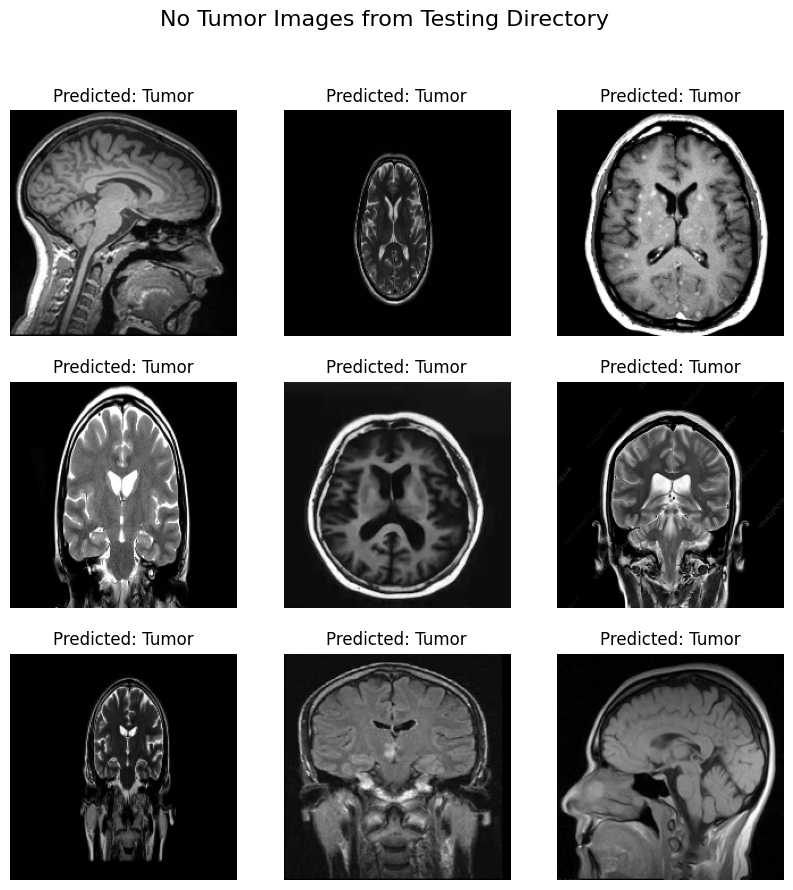

In [27]:

# Load the SVM model
svm_model = joblib.load('svm_model.pkl')

# Load and preprocess "No Tumor" images from the testing directory
no_tumor_images_path = '../data/tumor/Training/no_tumor/'
no_tumor_images = []
for image_name in os.listdir(no_tumor_images_path):
    img = cv2.imread(os.path.join(no_tumor_images_path, image_name), cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img = cv2.resize(img, (200, 200))
    no_tumor_images.append(img)
no_tumor_images = np.array(no_tumor_images)

# Flatten the images to 1D arrays
no_tumor_images_flattened = no_tumor_images.reshape(len(no_tumor_images), -1)

# Apply PCA to the "No Tumor" images from the testing directory
# Note: Define the pca_custom function properly before using it
no_tumor_images_pca = pca_custom(no_tumor_images_flattened / 255, threshold=1.0)  # Use threshold=1.0 to retain all components

# Truncate the PCA-transformed data to match the number of components used in the SVM model
# Define n_components properly before using it
no_tumor_images_pca = no_tumor_images_pca[:, :n_components]

# Make predictions for "No Tumor" images
no_tumor_predictions = svm_model.predict(no_tumor_images_pca)

# Debug print to identify the issue
print("Unique predictions:", np.unique(no_tumor_predictions))

# Display "No Tumor" Images from Testing Directory
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    index = np.random.randint(0, len(no_tumor_images))
    plt.imshow(no_tumor_images[index], cmap='gray')
    plt.title("Predicted: No Tumor" if no_tumor_predictions[index] == 0 else "Predicted: Tumor")
    plt.axis('off')
plt.suptitle("No Tumor Images from Testing Directory", fontsize=16)
plt.show()

Unique predictions: [-1.]


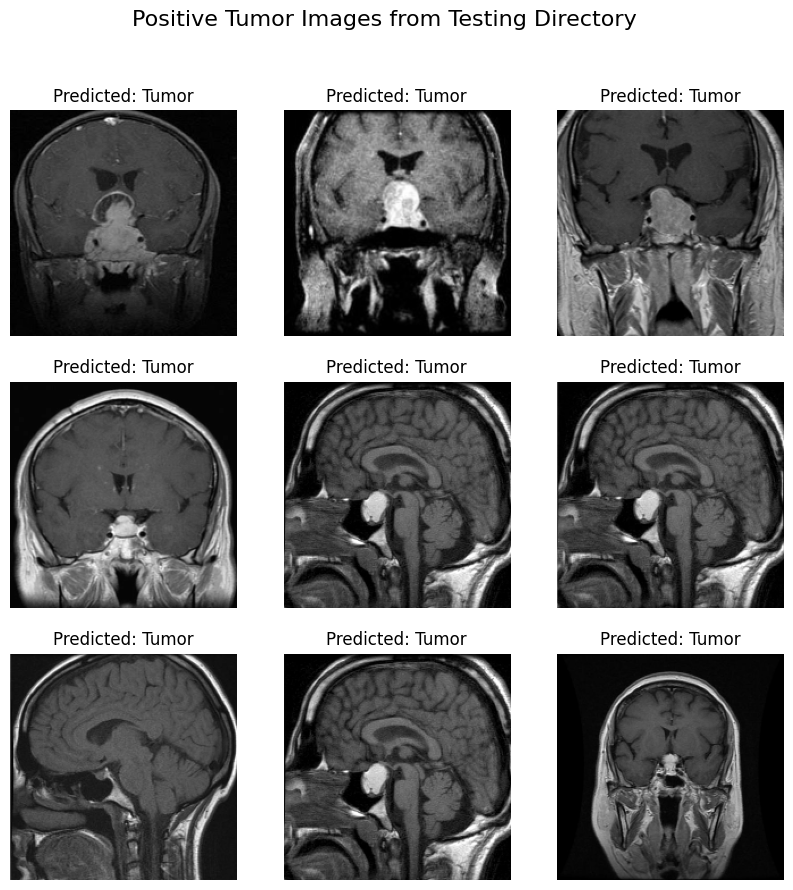

In [25]:
# Load and preprocess "Positive Tumor" images from the testing directory
positive_tumor_images_path = '../data/tumor/Testing/pituitary_tumor/'
positive_tumor_images = []
for image_name in os.listdir(positive_tumor_images_path):
    img = cv2.imread(os.path.join(positive_tumor_images_path, image_name), 0)  # Read image in grayscale
    img = cv2.resize(img, (200, 200))
    positive_tumor_images.append(img)
positive_tumor_images = np.array(positive_tumor_images)

# Flatten the images to 1D arrays
positive_tumor_images_flattened = positive_tumor_images.reshape(len(positive_tumor_images), -1)

# Apply PCA to the "Positive Tumor" images from the testing directory
positive_tumor_images_pca = pca_custom(positive_tumor_images_flattened / 255, threshold=1.0)  # Use threshold=1.0 to retain all components

# Truncate the PCA-transformed data to match the number of components used in the SVM model
positive_tumor_images_pca = positive_tumor_images_pca[:, :n_components]

# Make predictions for "Positive Tumor" images
positive_tumor_predictions = svm_model.predict(positive_tumor_images_pca)

# Debug print to identify the issue
print("Unique predictions:", np.unique(positive_tumor_predictions))

# Display "Positive Tumor" Images from Testing Directory
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    index = np.random.randint(0, len(positive_tumor_images))
    plt.imshow(positive_tumor_images[index], cmap='gray')
    plt.title("Predicted: No Tumor" if positive_tumor_predictions[index] == 0 else "Predicted: Tumor")
    plt.axis('off')
plt.suptitle("Positive Tumor Images from Testing Directory", fontsize=16)
plt.show()
